In [1]:
from utils import CustomDataset
from torch.utils.data import DataLoader
from Network.Resnet import ResNet
from Network.Mobilenet import MobileNet
from utils.MNISTTrain import train
from torch.utils.data import random_split
from torchvision import datasets
from torchvision.transforms import Compose, ToTensor, Normalize
import torch
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import colors as mcolors
from tqdm import tqdm
from torch import nn, int32, int64, float32, save
from torch.nn.functional import one_hot
from torchmetrics.classification import Accuracy, F1Score

/home/taehwan/MICCAI/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/taehwan/MICCAI/.venv/lib/python3.12/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (4.2.8) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In [6]:
# central = pd.read_csv("./Result/central/mnist/result.csv")
fedavg = pd.read_csv("Result/fedavg/FedAvg_mnist.csv")
fedprox = pd.read_csv("Result/fedprox/FedProx_mnist.csv")
fedrefp2 = pd.read_csv("Result/fedref/FedRef_mnist_lda01_p2.csv")
fedrefp5 = pd.read_csv("Result/fedref/FedRef_mnist_lda01_p5.csv")

In [ ]:
# net = MobileNet(outdim=10)
# optim = torch.optim.SGD(net.parameters(), lr=4e-3)

In [ ]:
# history=train(net.to(DEVICE), loader, tloader , 5, loss, optim, DEVICE, None)
# pd.DataFrame(history).to_csv("./Result/central/mnist/result.csv", index=False)

In [12]:
def ploting(fedavg, fedprox, fedref, title="MNIST Classification", zoom_min = 20, zoom_max=25):
    # 예시 데이터
    tableau_colors = list(mcolors.TABLEAU_COLORS.values())
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(fedavg["loss"], marker=".", linestyle="--",label="fedavg", color=tableau_colors[0])
    ax.plot(fedprox["loss"], marker=".", linestyle="--" ,label="fedprox(mu=0.5)", color=tableau_colors[1])
    for i,l in enumerate(fedref):
        ax.plot(l["loss"], marker=".", label=l["label"], color=tableau_colors[i+2], linestyle="--")

    # 메인 축 설정
    ax.set_title(title)
    ax.set_xlabel("Round")
    ax.set_ylabel("Loss")
    ax.legend()
    # 🔍 확대 구간 설정 (마지막 x값 근처, 예: x > 90)
    x_zoom_min = zoom_min
    x_zoom_max = zoom_max

    # inset 축 생성
    axins = inset_axes(ax, width="30%", height="40%", loc='upper center')
    axins.plot(fedavg["loss"], color =tableau_colors[0], label = "fedavg", linestyle="--")
    axins.plot(fedprox["loss"], color =tableau_colors[1], label = "fedprox", linestyle="--")
    for i,l in enumerate(fedref):
        axins.plot(l["loss"], label=l["label"], color=tableau_colors[i+2], linestyle="--")
        
    alp = []
    alp = fedavg["loss"][zoom_min:zoom_max+1].to_list() + fedprox["loss"][zoom_min:zoom_max+1].to_list()
    for l in fedref:
        alp = alp + l["loss"][zoom_min:zoom_max+1].to_list()
    
    axins.set_xlim(x_zoom_min, x_zoom_max)
    # 확대된 y축 범위도 지정하면 보기 쉬움
    # y_zoom = y[(x >= x_zoom_min) & (x <= x_zoom_max)]
    axins.set_ylim(min(alp), max(alp))

    # 확대된 영역 표시선 연결
    ax.indicate_inset_zoom(axins)
    ax.legend()
    
    ax.set_ylim(bottom=fedref[0]["loss"][len(fedref[0]["loss"])-1],top=fedavg["loss"][1])
    
    fig.show()
    

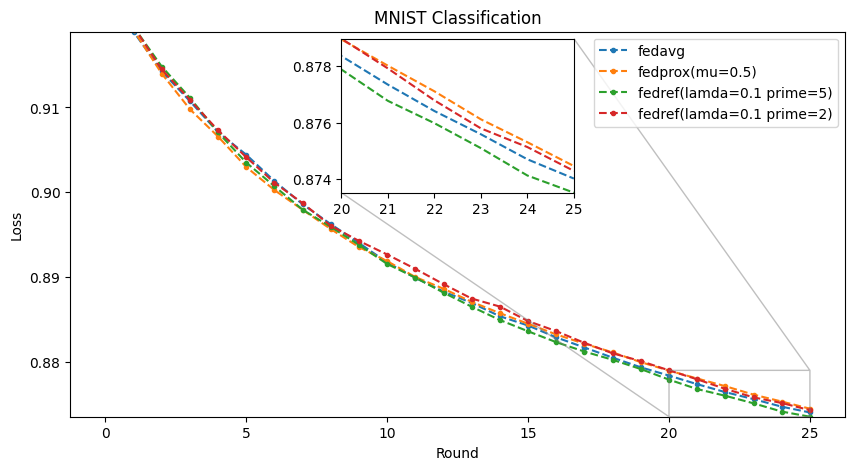

In [13]:
ploting(fedavg, fedprox, ({"loss":fedrefp5["loss"], "label":"fedref(lamda=0.1 prime=5)"}, {"loss":fedrefp2["loss"], "label":"fedref(lamda=0.1 prime=2)"}
                          ))
# {"loss":fedref09["loss"], "label": "fedref(lda=0.9, prime=2)"}

In [ ]:
DEVICE= torch.device("cuda" if torch.cuda.is_available() else "cpu")
# trainset = datasets.MNIST("./Data", True, Compose([ToTensor(), Normalize((0.5), (0.5))]), None, True)
testset = datasets.MNIST("./Data", False, Compose([ToTensor(), Normalize((0.5), (0.5))]), None, True)
# loader = DataLoader(trainset, 128, shuffle=True, collate_fn=lambda x:x)
tloader = DataLoader(testset, 128 , shuffle=True, collate_fn=lambda x:x)
lossf = torch.nn.BCEWithLogitsLoss().to(DEVICE)
net = MobileNet(outdim=10)
# optim = torch.optim.SGD(net.parameters(), lr=4e-3)

In [ ]:
def valid(net, valid_loader, e, lossf, DEVICE, Central=False):
    net.eval()
    Dicenary = {'accuracy':0, 'f1score':0}
    length = len(valid_loader) 
    losses = 0
    accf = Accuracy("multiclass", num_classes=10, multidim_average="global").to(DEVICE)
    f1scoref = F1Score("multiclass", num_classes=10, multidim_average="global").to(DEVICE)
    for sample in tqdm(valid_loader, desc="Validation: "):
    
        X= torch.stack([s[0] for s in sample], 0)
        Y= torch.Tensor([s[1] for s in sample])
    
        out = net(torch.stack([X.type(float32).to(DEVICE),X.type(float32).to(DEVICE),X.type(float32).to(DEVICE)], 1).squeeze()) 

        losses += lossf(out.type(float32).to(DEVICE), one_hot(Y.type(int64), 10).type(float32).squeeze().to(DEVICE)).item()
        
        Dicenary[f"accuracy"] += accf(out.type(float32).to(DEVICE), Y.type(int64).to(DEVICE)).item()
        Dicenary[f"f1score"] += f1scoref(out.type(float32).to(DEVICE), Y.type(int64).to(DEVICE)).item()

    # if Central:
        # logger.info(f"Result epoch {e+1}: loss:{losses/length} accuracy: {Dicenary["accuracy"]/length: .4f} f1score: {Dicenary["f1score"]/length: .4f}")
        
    return {"loss":losses/length, 'accuracy': Dicenary["accuracy"]/length , "f1score":Dicenary["f1score"]/length}

In [ ]:
# net.load_state_dict(torch.load("Models/FedAvgMNIST/net.pt"))
# net.to(DEVICE)
# valid(net, tloader, 0, lossf, DEVICE)